<a href="https://colab.research.google.com/github/keerthana-narra/MLOps-Integrated-Travel/blob/main/Colab-files/Flight_Ticket_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flight Ticket Price Prediction**



##### **Project Type**    - Machine Learning
##### **Contribution**    -


Github link :

Project Documentation : [Documentation link]

Presentation : [Video link]

# **Problem Statement and Objective**


**Problem Overview**



**Objective:**


# ***Let's Begin !***

## ***1. Know Your Data***

Before we diving into the project, our initial step is to familiarize ourselves with the dataset. Let's load the data and take a look.

### Import Libraries

In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import time


import warnings
warnings.filterwarnings('ignore')

In [4]:
#!pip install ipykernel
#!pip install numpy
#!pip install pandas
#!pip install matlplotlib
#!pip install seaborn
#!pip install sklearn-pandas==2.2.0
#!pip install xgboost

### Dataset Loading

In [5]:
#Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
#Load the dataset
# df=pd.read_csv('/content/drive/MyDrive/Almabetter/Masters/Specilization/Module1/Capstone/data/flights.csv')
df=pd.read_csv('../data/flights.csv')

In [7]:
# Change column names to lowercase with underscores instead of spaces
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Peek into data 👀

In [8]:
#First 5 rows
df.head(2)

,travelcode,usercode,from,to,flighttype,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019


In [9]:
#Last 5 rows
df.tail(2)

,travelcode,usercode,from,to,flighttype,price,time,distance,agency,date
271886,135943,1339,Florianopolis (SC),Rio de Janeiro (RJ),economic,313.62,1.21,466.3,CloudFy,07/23/2020
271887,135943,1339,Rio de Janeiro (RJ),Florianopolis (SC),economic,533.69,1.21,466.3,CloudFy,07/26/2020


In [10]:
# Dataset Rows & Columns
print(f'Shape of original dataframe:  {df.shape}')

Shape of original dataframe:  (271888, 10)


## ***2. Understanding Data & Preprocessing***

Moving forward to the next stage, our focus is on gaining a deeper understanding of the data and undertaking the initial preprocessing steps. These initial preprocessing efforts are crucial for enhancing the usability of the data in subsequent analyses.

### **Understanding Data**

In [11]:
#Variables in the dataset
print(f'Variables in the dataset : {list(df.columns)}')

Variables in the dataset : ['travelcode', 'usercode', 'from', 'to', 'flighttype', 'price', 'time', 'distance', 'agency', 'date']


**Variables Description**

- **travelCode:** Identifier for the travel.
- **userCode:** User identifier (linked to the Users dataset).
- **from:** Origin of the flight.
- **to:** Destination of the flight.
- **flightType:** Type of flight (e.g., first class).
- **price:** Price of the flight.
- **time:** Flight duration.
- **distance:** Distance of the flight.
- **agency:** Flight agency.
- **date:** Date of the flight.


In [12]:
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['data type'])
    summry['#missing'] = df.isnull().sum().values
    summry['#duplicate'] = df.duplicated().sum()
    summry['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['min'] = desc['min'].values
    summry['max'] = desc['max'].values
    summry['avg'] = desc['mean'].values
    summry['std dev'] = desc['std'].values
    summry['top value'] = desc['top'].values
    summry['freq'] = desc['freq'].values

    return summry

In [13]:
summary(df).style.set_caption(" Summary of the Data ").\
background_gradient(cmap='Blues', axis=0). \
set_properties(**{'border': '1.3px dotted', 'color': '', 'caption-side': 'left'})

,data type,#missing,#duplicate,#unique,min,max,avg,std dev,top value,freq
travelcode,int64,0,0,135944,0.000000,135943.000000,67971.500000,39243.724665,nan,nan
usercode,int64,0,0,1335,0.000000,1339.000000,667.505495,389.523127,nan,nan
from,object,0,0,9,nan,nan,nan,nan,Florianopolis (SC),57317
to,object,0,0,9,nan,nan,nan,nan,Florianopolis (SC),57317
flighttype,object,0,0,3,nan,nan,nan,nan,firstClass,116418
price,float64,0,0,490,301.510000,1754.170000,957.375030,362.311890,nan,nan
time,float64,0,0,33,0.440000,2.440000,1.421147,0.542541,nan,nan
distance,float64,0,0,35,168.220000,937.770000,546.955535,208.851288,nan,nan
agency,object,0,0,3,nan,nan,nan,nan,Rainbow,116752
date,object,0,0,999,nan,nan,nan,nan,09/26/2019,1335


In [14]:
def print_unique_counts(df, columns):
    for col in columns:
        unique_count = df[col].nunique()
        value_counts = df[col].value_counts()
        print(f"There are {unique_count} unique values and counts of each in {value_counts}\n")

# Columns to check uniques and values
columns_to_print = ['from', 'to', 'flighttype', 'agency']
print_unique_counts(df, columns_to_print)

There are 9 unique values and counts of each in from
Florianopolis (SC)     57317
Aracaju (SE)           37224
Campo Grande (MS)      34748
Brasilia (DF)          30779
Recife (PE)            30480
Natal (RN)             23796
Sao Paulo (SP)         23625
Salvador (BH)          17104
Rio de Janeiro (RJ)    16815
Name: count, dtype: int64

There are 9 unique values and counts of each in to
Florianopolis (SC)     57317
Aracaju (SE)           37224
Campo Grande (MS)      34748
Brasilia (DF)          30779
Recife (PE)            30480
Natal (RN)             23796
Sao Paulo (SP)         23625
Salvador (BH)          17104
Rio de Janeiro (RJ)    16815
Name: count, dtype: int64

There are 3 unique values and counts of each in flighttype
firstClass    116418
premium        78004
economic       77466
Name: count, dtype: int64

There are 3 unique values and counts of each in agency
Rainbow        116752
CloudFy        116378
FlyingDrops     38758
Name: count, dtype: int64



### ***Data Preprocessing***
This step before EDA helps us to understand data easily further
1. Drop the unique identifier and check for duplicates. As the unique identifier is a row generator.
2. Date type conversion.
3. Fill missing values in customer review column with ''


In [15]:
# This function helps us to check and drop duplicates whenever required
def check_drop_duplications(df):
  if len(df[df.duplicated()]) > 0:
    print(f'Count of duplicate rows : {len(df[df.duplicated()])}')
    print(f'Dropping duplicates')
    df = df.drop_duplicates()
  else:
    print(f'There are no duplicates.')
  return df

In [16]:
# Dropping identifiers
df = df.drop(columns = ['travelcode','usercode'])

In [17]:
# Lets see if we have any duplicate rows
df = check_drop_duplications(df)

Count of duplicate rows : 122404
Dropping duplicates


In [18]:
# Converting datetime columns to same format
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)

## ***3. Exploratory Data Analysis***

#### Chart-1 Numerical features distribution

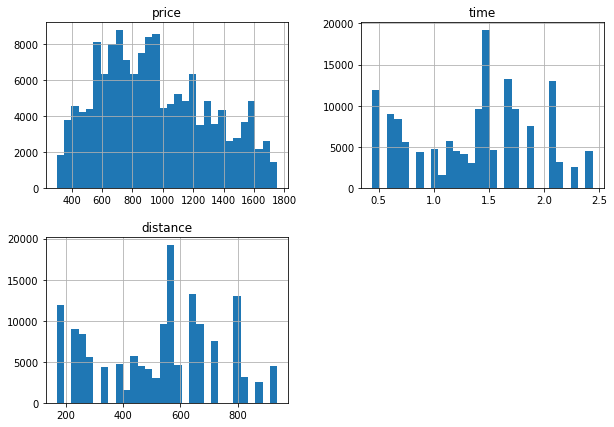

In [19]:
# Check the distributions of price, time and distance.
numerical_features = ['price', 'time', 'distance']
df[numerical_features].hist(bins=30, figsize=(10, 7))
plt.show()

#### Chart - 2 Categorical features distribution



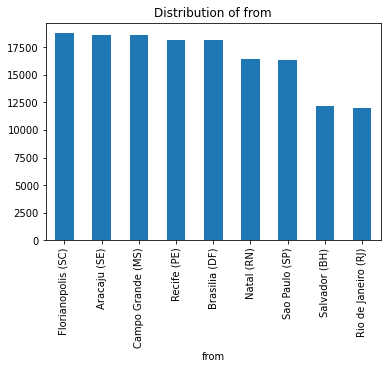

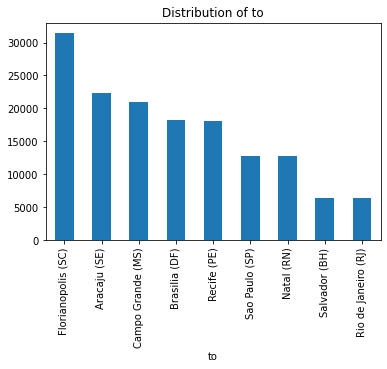

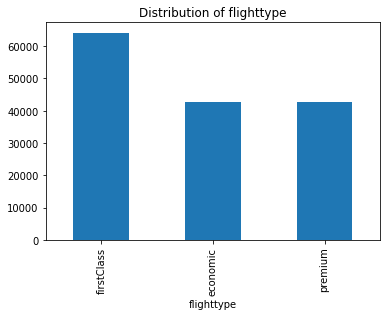

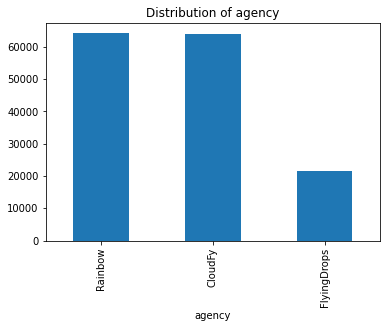

In [20]:
categorical_features = ['from', 'to', 'flighttype', 'agency']

for feature in categorical_features:
    df[feature].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {feature}')
    plt.show()

#### Chart 3 - Correlation between price and time, distance

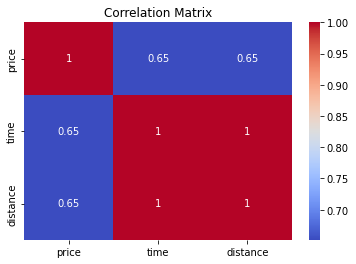

In [21]:
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Chart 4 - Categorical features over numerical features distributions

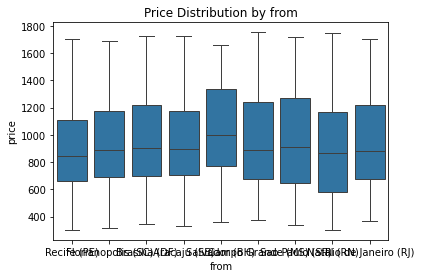

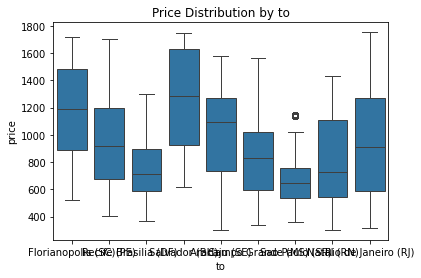

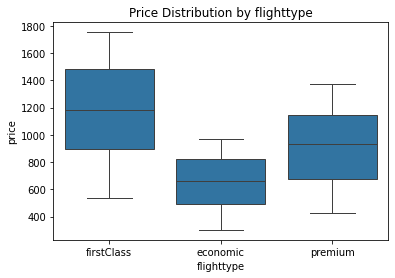

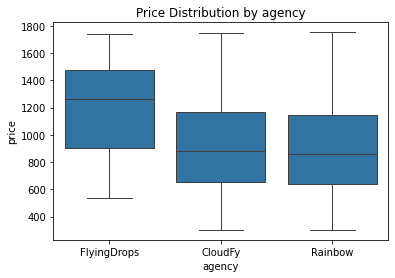

In [22]:
for feature in categorical_features:
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f'Price Distribution by {feature}')
    plt.show()

#### Chart - 5 Price over time

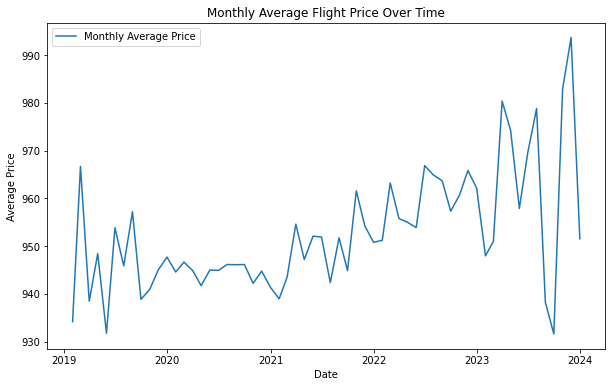

In [23]:
# Aggregate data to get average price per month
monthly_avg_price = df[['date','price']]
monthly_avg_price.set_index('date', inplace = True)
monthly_avg_price = monthly_avg_price['price'].resample('M').mean()

# Plot average price per month
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price, label='Monthly Average Price')
plt.title('Monthly Average Flight Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.show()

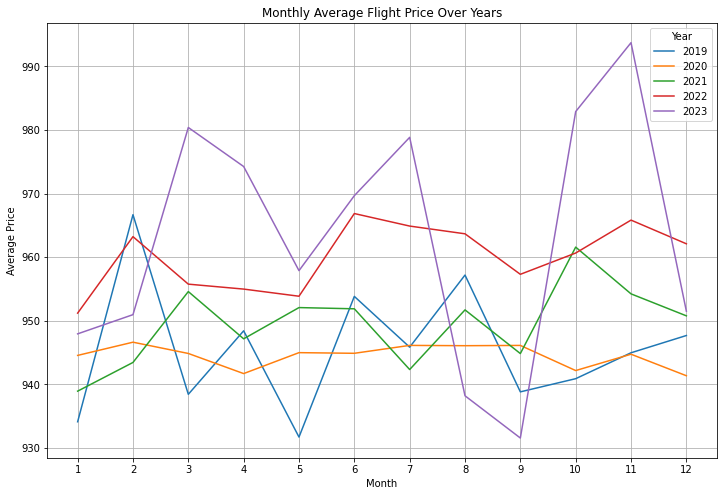

In [24]:
# Create a separate DataFrame for monthly average price calculations
monthly_avg_df = df.copy()

# Extract year and month from the date
monthly_avg_df['year'] = monthly_avg_df['date'].dt.year
monthly_avg_df['month'] = monthly_avg_df['date'].dt.month

# Calculate monthly average price
monthly_avg_price = monthly_avg_df.groupby(['year', 'month'])['price'].mean().unstack(level=0)

# Plot the monthly average price for each year
plt.figure(figsize=(12, 8))
for year in monthly_avg_price.columns:
    plt.plot(monthly_avg_price.index, monthly_avg_price[year], label=str(year))

plt.title('Monthly Average Flight Price Over Years')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.legend(title='Year')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

### Overall Insights

## ***4. Feature Engineering***

### 1. Feature Engineering

In [25]:
# Load these functions in predict.py

# Define fixed holiday dates
fixed_holidays = {
    'new_year': (1, 1),
    'valentines': (2, 14),
    'christmas': (12, 25)
}

def get_mothers_day(year):
    """Return the date of the second Sunday in May for the given year."""
    may_first = pd.Timestamp(year, 5, 1)
    # Find the first Sunday in May
    first_sunday = may_first + pd.offsets.Week(weekday=6)
    # Mother's Day is the second Sunday in May
    mothers_day = first_sunday + pd.offsets.Week(weekday=6)
    return mothers_day

def get_thanksgiving(year):
    """Return the date of the fourth Thursday in November for the given year."""
    nov_first = pd.Timestamp(year, 11, 1)
    # Find the first Thursday in November
    first_thursday = nov_first + pd.offsets.Week(weekday=3)
    # Thanksgiving is the fourth Thursday in November
    thanksgiving = first_thursday + pd.offsets.Week(weekday=3, n=3)
    return thanksgiving

def get_cyber_monday(year):
    """Return the date of the Monday after Thanksgiving for the given year."""
    thanksgiving = get_thanksgiving(year)
    cyber_monday = thanksgiving + pd.DateOffset(days=4)
    return cyber_monday

def is_holiday(date):
    # Check fixed holidays
    for month, day in fixed_holidays.values():
        holiday_date = pd.Timestamp(date.year, month, day)
        if abs((date - holiday_date).days) <= 7:
            return 1

    # Check dynamic holidays
    year = date.year

    # Mother's Day
    mothers_day = get_mothers_day(year)
    if abs((date - mothers_day).days) <= 7:
        return 1

    # Thanksgiving
    thanksgiving = get_thanksgiving(year)
    if abs((date - thanksgiving).days) <= 7:
        return 1

    # Cyber Monday
    cyber_monday = get_cyber_monday(year)
    if abs((date - cyber_monday).days) <= 7:
        return 1

    return 0

In [26]:
# Create new features
df['is_holiday_period'] = df['date'].apply(is_holiday)
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['weeknum'] = df['date'].dt.isocalendar().week
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

### 2. Drop Unnecesary columns

In [27]:
# Drop unnecessary columns and columns with very high percentage of nulls
# Drop columns which are not useful because of high number of missing values or high number of categories
drop_cols = ['date']
df = df.drop(columns=drop_cols)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 149484 entries, 0 to 271851
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   from               149484 non-null  object 
 1   to                 149484 non-null  object 
 2   flighttype         149484 non-null  object 
 3   price              149484 non-null  float64
 4   time               149484 non-null  float64
 5   distance           149484 non-null  float64
 6   agency             149484 non-null  object 
 7   is_holiday_period  149484 non-null  int64  
 8   month              149484 non-null  int32  
 9   weekday            149484 non-null  int32  
 10  weeknum            149484 non-null  UInt32 
 11  is_weekend         149484 non-null  int32  
dtypes: UInt32(1), float64(3), int32(3), int64(1), object(4)
memory usage: 12.7+ MB


In [28]:
# check duplicates after removing date
df = check_drop_duplications(df)

Count of duplicate rows : 47288
Dropping duplicates


In [29]:
#Identify unique combinations and aggregate by average
df_temp = check_drop_duplications(df[['from','to','flighttype','agency','time','distance']])

df_temp = df.groupby(['from', 'to', 'flighttype', 'agency'], as_index=False).agg({
    'time': 'mean',
    'distance': 'mean'
})

# Step 1.3: Save df_temp to a CSV file
df_temp.to_csv('load_distance_time.csv', index=False)
print("DataFrame with unique combinations and averages saved to 'load_distance_time.csv'.")

Count of duplicate rows : 101706
Dropping duplicates
DataFrame with unique combinations and averages saved to 'load_distance_time.csv'.


## ***5. Transformation on Train Data***

In [30]:
# Separate features (X) and target variable (y)
X = df.drop(columns=['price'])
y = df['price']

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


### 1. Encoding

In [32]:
X_train.columns

Index(['from', 'to', 'flighttype', 'time', 'distance', 'agency',
       'is_holiday_period', 'month', 'weekday', 'weeknum', 'is_weekend'],
      dtype='object')

In [33]:
# Initialize the encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Columns to encode
columns_for_one_hot_encoding = ['from', 'to', 'flighttype', 'agency']

# Fit & transform encoder
X_train_cat = encoder.fit_transform(X_train[columns_for_one_hot_encoding])

# Save the fitted encoder
with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

### 2. Data Transformation

In [34]:
# Initialize the scaler
scaler = MinMaxScaler()

# Columns for scaling
numerical_features = ['time', 'distance', 'is_holiday_period', 'month', 'weekday', 'weeknum', 'is_weekend']

# Fit & transfrom scaler
X_train_num = scaler.fit_transform(X_train[numerical_features])


# Save the fitted encoder
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


## ***6.Modelling & Evaluation***

In [35]:
# Stack numerical and categorical features
X_train = np.hstack((X_train_num, X_train_cat))

In [36]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
# Define a function to calculate adjusted R²
def adjusted_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    time_taken = time.time() - start_time

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2_score(r2, X_test.shape[0], X_test.shape[1])
    explained_variance = explained_variance_score(y_test, y_pred)

    return rmse, r2, adj_r2, explained_variance, time_taken

# Initialize a dictionary to store results
results = {}

# Train and evaluate Linear Regression model
lr_model = LinearRegression()
results['Linear Regression'] = train_evaluate_model(lr_model, X_train, y_train, X_val, y_val)

# Train and evaluate Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
results['Random Forest'] = train_evaluate_model(rf_model, X_train, y_train, X_val, y_val)

# Train and evaluate XGBoost model
xgb_model = XGBRegressor()
results['XGBoost'] = train_evaluate_model(xgb_model, X_train, y_train, X_val, y_val)

# Convert results to a DataFrame
results_df = pd.DataFrame(results, index=['RMSE', 'R²', 'Adjusted R²', 'Explained Variance', 'Time Taken (s)']).T
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)

results_df


,Model,RMSE,R²,Adjusted R²,Explained Variance,Time Taken (s)
0,Linear Regression,104.498855,0.914735,0.914591,0.914737,0.199556
1,Random Forest,0.647430,0.999997,0.999997,0.999997,23.001654
2,XGBoost,1.382327,0.999985,0.999985,0.999985,0.602520


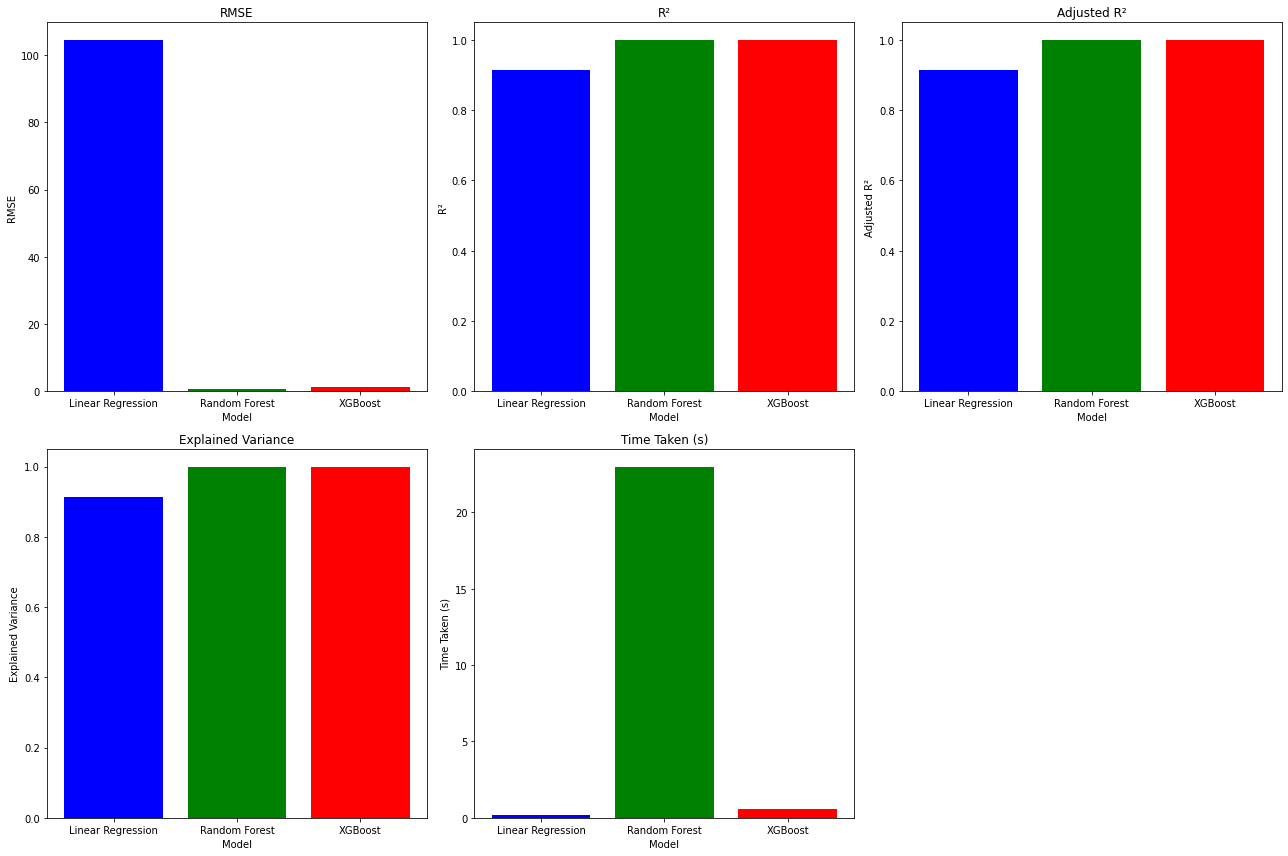

In [39]:
# Plot the results
metrics = ['RMSE', 'R²', 'Adjusted R²', 'Explained Variance', 'Time Taken (s)']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    axes[row, col].bar(results_df['Model'], results_df[metric], color=['blue', 'green', 'red'])
    axes[row, col].set_title(metric)
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_xlabel('Model')

# Remove the unused subplot
fig.delaxes(axes[1][2])

plt.tight_layout()
plt.show()


#### Comparing all three models from the metrics considered selecting XGBoost and continuning to hyperparameter tuning

In [40]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=2,  # Number of parameter settings sampled
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1  # Use all available CPUs
    )

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Evaluate the best model
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
adj_r2 = adjusted_r2_score(r2, X_val.shape[0], X_val.shape[1])
explained_variance = explained_variance_score(y_val, y_pred)

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adj_r2}")
print(f"Explained Variance: {explained_variance}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 1.0}
RMSE: 0.24826880896324385
R²: 0.9999995187254357
Adjusted R²: 0.9999995179130031
Explained Variance: 0.9999995187320317


In [41]:
# Get the best model
best_xgb_model = random_search.best_estimator_

# Save the best model, encoder, and scaler
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

## ***7.Predictions on test data***

In [42]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# load this cell in predict.py

def preprocess(input_data):
  if 'date' in input_data.columns:
      # Ensure date is in datetime format
      input_data['date'] = pd.to_datetime(input_data['date'])

      # Calculate date related parameters
      input_data['month'] = input_data['date'].dt.month
      input_data['weekday'] = input_data['date'].dt.weekday
      input_data['weeknum'] = input_data['date'].dt.isocalendar().week
      input_data['is_weekend'] = input_data['weekday'].isin([5, 6]).astype(int)
      input_data['is_holiday_period'] = input_data['date'].apply(is_holiday).astype(int)
  return input_data

def predict(input_data):
  # Preprocess and create features for test
  input_data = preprocess(input_data)

  # Load the encoder and scaler for use on new data
  with open('encoder.pkl', 'rb') as file:
      loaded_encoder = pickle.load(file)

  with open('scaler.pkl', 'rb') as file:
      loaded_scaler = pickle.load(file)

  # Separate categorical and numerical features
  columns_for_one_hot_encoding = ['from', 'to', 'flighttype', 'agency']
  numerical_features = ['time', 'distance', 'is_holiday_period', 'month', 'weekday', 'weeknum', 'is_weekend']

  # Transform new data using the loaded encoder and scaler
  input_data_cat = loaded_encoder.transform(input_data[columns_for_one_hot_encoding])
  input_data_num = loaded_scaler.transform(input_data[numerical_features])

  input_data = np.hstack((input_data_num, input_data_cat))

  with open('best_xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

  y_pred = loaded_model.predict(input_data)

  return y_pred

In [43]:
# Predicting and Evaluating on Test set

y_pred = predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = adjusted_r2_score(r2, X_test.shape[0], X_test.shape[1])
explained_variance = explained_variance_score(y_test, y_pred)

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adj_r2}")
print(f"Explained Variance: {explained_variance}")

RMSE: 0.2461748926097136
R²: 0.9999995261132418
Adjusted R²: 0.999999525602588
Explained Variance: 0.9999995261755651


In [ ]:
!pip freeze > requirements.txt

# **Conclusion**